# Infectious disease modelling

*Mathematical models* of diseases are tools used by epidemiologists, public health experts, and mathematicians to understand, predict, and control the spread of infectious diseases within populations. These models use mathematical equations to represent various aspects of disease transmission, such as the rate of infection, recovery, and death. 

## Types of disease models: overview

```{margin}
In some literature, ABMs are also called IBMs, for *individual-based models*. 
```
Such models can be deterministic or stochatisc; expressed as *compartmental Models* or *agent-based models (ABMs)*; they can be purely temporal or *spatial models*, or *network models*. Some common mathematical models of diseases include:

- **Compartmental Models**: These are the most common type of mathematical models used in epidemiology. Compartmental models divide the population into different compartments based on disease status. The prototypical compartmental model is the SIR model, which divides the population into three compartments: Susceptible (S), Infected (I), and Recovered (R). Extensions of this model include the SEIR model (which includes an Exposed compartment) and the SIRS model (which allows individuals to become susceptible again after recovery) and other.

- **Agent-Based Models (ABMs)**: Agent-based models simulate the actions and interactions of individuals within a population. Each individual (or agent) is represented separately and can have unique characteristics and behaviors. ABMs are useful for studying complex systems and behaviors that cannot be captured by compartmental models, such as individual-level heterogeneity and spatial dynamics.

- **Network Models**: Network models represent the population as a network of interconnected nodes, with each node representing an individual and edges representing contacts between individuals. These models are particularly useful for studying diseases that spread through social networks, such as sexually transmitted infections or airborne diseases in close-knit communities.

- **Stochastic Models**: Stochastic models incorporate randomness into the modeling process. Unlike deterministic models, which produce exact predictions based on fixed parameters, stochastic models account for probabilistic events such as chance encounters between individuals and random variations in disease transmission. Stochastic models are particularly useful for studying small populations or rare events.

These are just a few examples of the many mathematical models used to study disease transmission. Each type of model has its own strengths and limitations, and the choice of model depends on the specific characteristics of the disease being studied and the questions being addressed by researchers.

## Outbreak modelling

In this lecture, we will explore modeling options for studying outbreaks.

A mathematical model is a mathematical representation of a system, that can be used to explore its behaviour. The goals of *real-time* infectious disease modelling is to 

- Look at data from an outbreak so far, 
- Construct a model that represents the underlying epidemiology of the system, 
- Perform simulations of the model *forward* to *predict* what might likely happen in the future (how many cases are we expecting to see per day?), 
- Introduce *control intervnetions* into the model to look at how different control intervention might effect the outcomes we would like to see in the future.

## Key questions

The two key questions here are

1). How do we build a mathematical model of an outbreak?

In this lecture we will investigate the following quetsions:

- Is there a characteristic "shpae" of an infectious idsease outbreak?
- Building a simple infectious disease outbreak model,
- What is the basic reproduction number $R_0$ and how is it used,
- Extensions of the simple model.

2). How can models be used to inform public health measures at *different stages* of an outbreak?

- Early in an outbreak
- When a major outbreak is ongoing
- End of an outbreak

### Boarding school data

This dataset contains records of an outbreak of influenza A (H1N1) in 1978 at a British boarding school. The data consists of the daily number of students in bed (prevalence data), spanning over a time interval of 14 days. 

There were 763 male students who were mostly full boarders and 512 of them became ill. The outbreak lasted from the 22nd of January to the 4th of February. It is reported that one infected boy started the epidemic, which spread rapidly in the relatively closed community of the boarding school. The data are freely available in the R package `outbreaks`, maintained as part of the [R Epidemics Consortium](https://www.repidemicsconsortium.org/), and is a great resource for trying to fit different models yourself after the course.

In [2]:
import pandas as pd

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Specify the path to CSV file woth data
csv_file = "data/influenza_england_1978_school.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(csv_file)

# Rename the 'Unnamed: 0' column to 't'
data = data.rename(columns={'Unnamed: 0': 't'})

data.head()

,t,date,in_bed,convalescent
0,1,1978-01-22,3,0
1,2,1978-01-23,8,0
2,3,1978-01-24,26,0
3,4,1978-01-25,76,0
4,5,1978-01-26,225,9


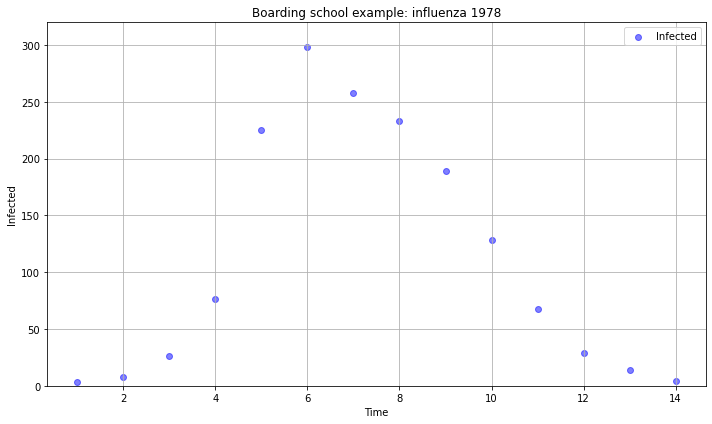

In [4]:
# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot 'in_bed' against 'date'
plt.scatter(data['t'], data['in_bed'], color='blue', alpha=0.5, label='Infected')

# Set the labels and title
plt.xlabel('Time')
plt.ylabel('Infected')
plt.ylim(0, 320)
plt.title('Boarding school example: influenza 1978')

# Show the plot
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


### The "shape"

Most *single-wave* infectious disease outbreaks tend to have a characteristic shape: at the start, the number of infected individuals increases, reaches its peaks, and then goes down back to near zero.


### A simple mathmatical model: exponential growth

We would like to recreate that shape using a mathematical model.

The simplest possible assumption about how a disease spreads is that each case of disease leads on to some fixed number of new cases every day. 

```{tikz}  
  [level distance=20mm,level/.style={sibling distance=40mm/#1}]
  \node[circle, draw, fill=red!30] {D0}
    child {node[circle, draw, fill=red!30] {D1}
      child {node[circle, draw, fill=red!30] {D2}}
      child {node[circle, draw, fill=red!30] {D2}}
    }
    child {node[circle, draw, fill=red!30] {D1}
      child {node[circle, draw, fill=red!30] {D2}}
      child {node[circle, draw, fill=red!30] {D2}}
    };
```

Day 0: 1 

Day 1: 2

Day 2: 4=2^2

Day 3: 8=3^2

```{margin}
Verify the formula for geomtric progression. What is the total number of infections by day $T$?
```
This model is a *geometric progression*. According to it, every day the number of new cases is

$$
I_t = 2^t
$$

Would this model look like any real data?